In [176]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt     #pyplot is a collection of functions to make Python work like MATLAB
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import os

os.chdir('C:\\Users\\Arthur\\my_projects\\Bachelorarbeit\\jupyter_project\\data\\Roenfeld')

borders = cfeature.NaturalEarthFeature( #cfeature draws Mapdata from a Database
    category='cultural',
    name='admin_0_countries',
    scale='10m',
    facecolor='none')


graz_lat = 47.0667
graz_lon = 15.45
os.listdir()

['.Rhistory',
 'EOBS_2008_monmean.nc',
 'EOBS_orog.nc',
 'INCA_2008_monmean.nc',
 'INCA_2008_monmean_EOBS.nc',
 'INCA_2008_monmean_SPARTACUS.nc',
 'INCA_orog.nc',
 'INCA_orog_EOBS.nc',
 'INCA_orog_SPARTACUS.nc',
 'map.pdf',
 'map.png',
 'README.txt',
 'SPARTACUS_2008_monmean.nc',
 'SPARTACUS_2008_monmean_EOBS.nc',
 'SPARTACUS_orog_EOBS.nc']

In [177]:
DS_temp1 = xr.open_dataset('INCA_2008_monmean.nc')
DS_orog1 = xr.open_dataset('INCA_orog.nc')
DS_temp2 = xr.open_dataset('SPARTACUS_2008_monmean.nc')

In [178]:
DS_temp.head

<bound method Dataset.head of <xarray.Dataset>
Dimensions:  (time: 12, x: 701, y: 401)
Coordinates:
    lon      (y, x) float64 8.444 8.457 8.47 8.483 ... 17.7 17.72 17.73 17.74
    lat      (y, x) float64 45.77 45.77 45.77 45.77 ... 49.4 49.4 49.4 49.4
  * time     (time) datetime64[ns] 2008-01-31T23:00:00 ... 2008-12-31T23:00:00
Dimensions without coordinates: x, y
Data variables:
    T2M      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    CDI:                       Climate Data Interface version 1.6.4 (http://c...
    history:                   Fri Nov 30 12:33:15 2018: cdo monmean INCA_200...
    Conventions:               CF-1.5
    provider:                  ZAMG (Central Institution for Meteorology and ...
    title:                     INCA (Integrated Nowcasting through Comprehens...
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.6.4 (http://c...>

<Figure size 1296x864 with 0 Axes>

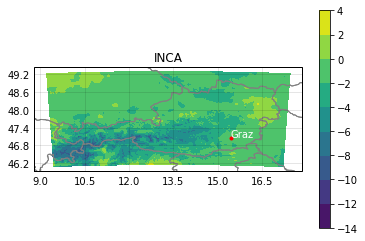

In [179]:
fig = plt.figure(figsize=(18,12))
fig,ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

cnt = plt.contourf(DS_temp1.lon,DS_temp1.lat,DS_temp1.T2M[0],transform=ccrs.PlateCarree())
plt.colorbar(cnt)

ax.add_feature(borders,edgecolor = 'gray')
ax.plot(graz_lon,graz_lat,
         color='red', linewidth=1, marker='.')
ax.text(graz_lon,graz_lat,'Graz',
         color='white', horizontalalignment = 'left')

g = ax.gridlines(draw_labels=True,
                  linewidth=1, color='black', alpha=0.1,transform=ccrs.PlateCarree())
g.xlabels_top = False
g.ylabels_right = False
ax.set_title('INCA')
plt.show()



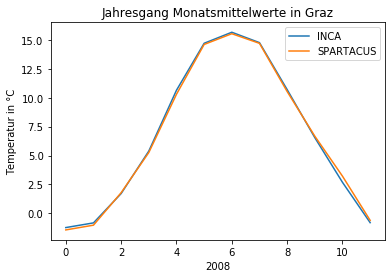

In [180]:
plt.plot(DS_temp1.T2M[:,134,541],label='INCA')
plt.plot(DS_temp2.tasmin[:,79,449],label='SPARTACUS')

plt.title("Jahresgang Monatsmittelwerte in Graz")

plt.xlabel('2008')
plt.ylabel('Temperatur in °C')

plt.legend()